# Convolutional Neural Networks

{{ badge }}


A Convolutional Neural Network (ConvNet/CNN) is a Deep Learning algorithm which can take in an input image, assign importance (learnable weights and biases) to various aspects/objects in the image and be able to differentiate one from the other. The pre-processing required in a ConvNet is much lower as compared to other classification algorithms. While in primitive methods filters are hand-engineered, with enough training, ConvNets have the ability to learn these filters/characteristics.

In this tutorial we will build a CNN based model using TensorFlow


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Download & Preprocess Data

We will be using the CIFAR10 dataset, which contains 60,000 color images in 10 classes, with 6,000 images in each class. The dataset is divided into 50,000 training images and 10,000 testing images. The classes are mutually exclusive and there is no overlap between them.

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

The targets' shape is (50000, 1) and (10000, 1), 50000 and 10000 refer to the number of samples in the training and testing set respectively, while the 1 means that the value of each sample is an array with a single value, to prepare the data to be one-hot encoded, we will remove the array and keep only the integer value

In [ ]:
print("Target values before reshaping: ", y_train[0], y_test[0])

y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)

print("Target values after reshaping: ", y_train[0], y_test[0])

x_train.shape, y_train.shape, x_test.shape, y_test.shape

Target values before reshaping:  [6] [3]
Target values after reshaping:  6 3


((50000, 32, 32, 3), (50000,), (10000, 32, 32, 3), (10000,))

In [ ]:
# Normalize pixel values to be between 0 and 1
x_train = x_train / 255.0
x_test = x_test / 255.0

# Convert the labels to one hot vectors
y_train = tf.one_hot(y_train, depth=10)
y_test = tf.one_hot(y_test, depth=10)

y_train[0], tf.argmax(y_train[0])

(<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)>,
 <tf.Tensor: shape=(), dtype=int64, numpy=6>)

To verify that the dataset is loaded correctly, let's plot the first 25 images from the training set and display the class name under each image.

The description (i.e. `class_name`) is taken from CIFAR10's documentation here: https://www.cs.toronto.edu/~kriz/cifar.html


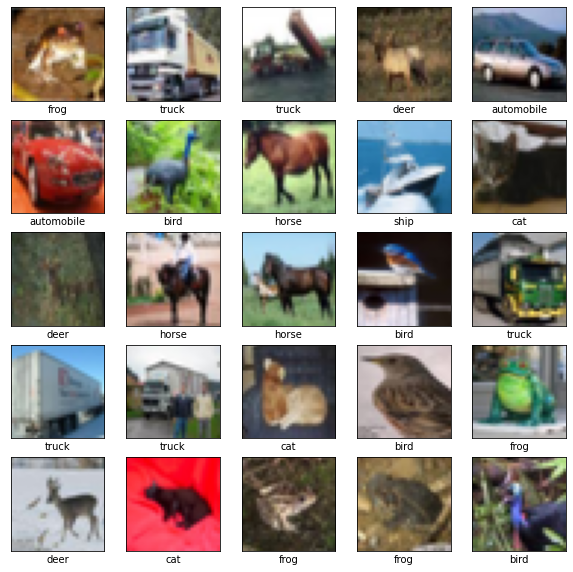

In [ ]:
# The ordering of the labels corresponds to the target
class_names = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

plt.figure(figsize=(10, 10))  # Set the size of the plot

for i in range(25):

    plt.subplot(5, 5, i + 1)  # Create a subplot on a 5x5 grid for index i

    plt.xticks([])  # Remove the ticks of the number line from the x axis
    plt.yticks([])  # Remove the ticks of the number line from the y axis

    plt.imshow(
        x_train[i]
    )  # Plot the image, no need to use the cmap parameter since this image is in RGB

    target_index = tf.argmax(
        y_train[i]
    )  # Convert the one-hot encoding to the original value
    plt.xlabel(class_names[target_index])  # Add the class name below the image

## Convolutional Neural Network Model

As input, a CNN takes tensors of shape (image_height, image_width, color_channels), ignoring the batch size. If you are new to these dimensions, color_channels refers to (R,G,B). In this example, you will configure our CNN to process inputs of shape (32, 32, 3), which is the format of CIFAR images. You can do this by passing the tf.keras.layers.Input((32,32,3)).

The CNN part of the neural network does feature extraction, and it will be followed by a feed forward `Dense` network to classify the input image based on the feature vectors that the CNN produced. The feature vectors need to be flattened before being passed to the `Dense` layers, this is done using the `Flatten` layer via `tf.keras.layers.Flatten()`.

In [ ]:
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Conv2D(
            64,
            kernel_size=3,
            activation="relu",
            padding="same",
            input_shape=[32, 32, 3],
        ),
        tf.keras.layers.MaxPooling2D(2),
        tf.keras.layers.Conv2D(128, kernel_size=3, activation="relu", padding="same"),
        tf.keras.layers.Conv2D(128, kernel_size=3, activation="relu", padding="same"),
        tf.keras.layers.MaxPooling2D(2),
        tf.keras.layers.Conv2D(256, kernel_size=3, activation="relu", padding="same"),
        tf.keras.layers.Conv2D(256, kernel_size=3, activation="relu", padding="same"),
        tf.keras.layers.MaxPooling2D(2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation="softmax"),
    ]
)

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 16, 16, 128)       73856     
                                                                 
 conv2d_22 (Conv2D)          (None, 16, 16, 128)       147584    
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 8, 8, 128)        0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 8, 8, 256)        

Above, you can see that the output of every Conv2D and MaxPooling2D layer is a 3D tensor of shape (height, width, channels). The height and width dimensions stay the same since we're using `same` padding, however the height and width shrinked by half when passed via a `MaxPooling2D` layer since the default size of the pooling filter is 2x2.

The number of output channels for each Conv2D layer is controlled by the first argument (e.g., 32 , 64 or 128). Typically, as the width and height shrink, you can afford (computationally) to add more output channels in each Conv2D layer.

As you can see, our (4, 4, 256) outputs from the max_pooling2d_6 were flattened into vectors of shape (4096) before going through three Dense layers.

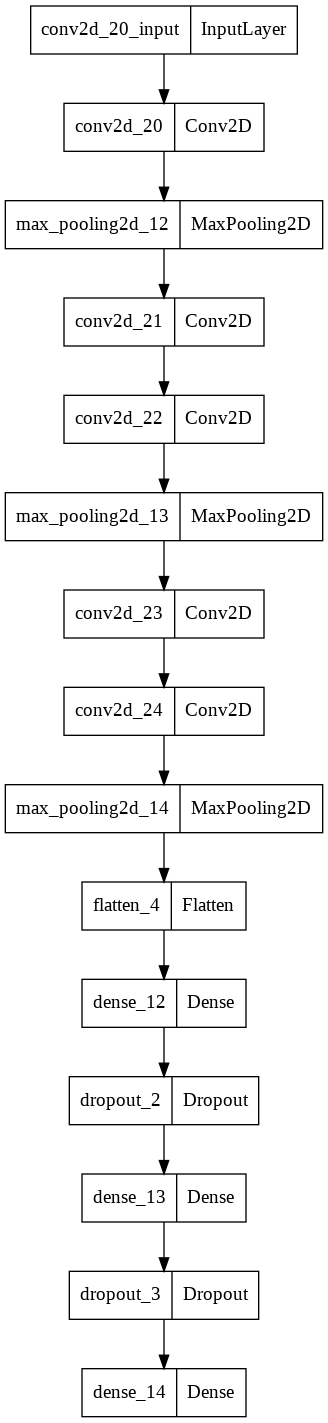

In [ ]:
tf.keras.utils.plot_model(model)

• The first layer uses 64  filters (3 × 3). It also sets input_shape=[32, 32, 3], because the
images are 32 × 32 pixels, with a 3 color channel (i.e., RGB)

• Next we have a max pooling layer which uses a pool size of 2, so it divides each spatial dimension by a factor of 2.

• Then we repeat the same structure twice: two convolutional layers followed by a max pooling layer. For larger images, we could repeat this structure several more times (the number of repetitions is a hyperparameter you can tune).

• Note that the number of filters grows as we climb up the CNN toward the output layer (it is initially 64, then 128, then 256): it makes sense for it to grow, since the
number of low-level features is often fairly low (e.g., small circles, horizontal lines), but there are many different ways to combine them into higher-level features. It is a common practice to double the number of filters after each pooling layer: since a pooling layer divides each spatial dimension by a factor of 2, we can afford to double the number of feature maps in the next layer without fear of exploding the number of parameters, memory usage, or computational load.

• Next is the fully connected network, composed of two hidden dense layers and a dense output layer. Note that we must flatten its inputs, since a dense network expects a 1D array of features for each instance. We also add two dropout layers,with a dropout rate of 50% each, to reduce overfitting.


## Compile & Train

We'll compile the model using `Adam` optimizer and `CategoricalCrossentropy`. 

Then we'll fit the model using the training data for 5 epoches, since the default mini-batch size is 32, we'll have ~1563 mini-batches in each epoch (i.e. 1563 weight updates).

In [ ]:
model.compile(
    optimizer=tf.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=["accuracy"],
)

model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))

Epoch 1/5
1563/1563 [==============================] - 28s 17ms/step - loss: 1.9840 - accuracy: 0.2362 - val_loss: 1.6174 - val_accuracy: 0.3698
Epoch 2/5
1563/1563 [==============================] - 27s 17ms/step - loss: 1.6037 - accuracy: 0.3915 - val_loss: 1.4155 - val_accuracy: 0.4740
Epoch 3/5
1563/1563 [==============================] - 27s 17ms/step - loss: 1.4081 - accuracy: 0.4875 - val_loss: 1.2295 - val_accuracy: 0.5667
Epoch 4/5
1563/1563 [==============================] - 28s 18ms/step - loss: 1.2656 - accuracy: 0.5536 - val_loss: 1.1862 - val_accuracy: 0.5922
Epoch 5/5
1563/1563 [==============================] - 27s 17ms/step - loss: 1.1681 - accuracy: 0.5972 - val_loss: 1.0112 - val_accuracy: 0.6418


## Plot Training History

In [ ]:
train_history = pd.DataFrame(model.history.history)
train_history

,loss,accuracy,val_loss,val_accuracy
0,1.983985,0.23618,1.617361,0.3698
1,1.603725,0.39154,1.415495,0.4740
2,1.408131,0.48752,1.229497,0.5667
3,1.265598,0.55364,1.186179,0.5922
4,1.168114,0.59716,1.011237,0.6418


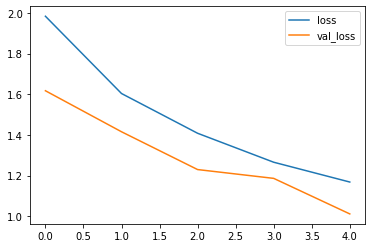

In [ ]:
train_history[["loss", "val_loss"]].plot.line()

# BatchNormalization
Batch-Normalization (BN) is an algorithmic method which makes the training of Deep Neural Networks (DNN) faster and more stable.
It consists of normalizing activation vectors from hidden layers using the first and the second statistical moments (mean and variance) of the current batch. This normalization step is applied right before the nonlinear function.
BatchNormalization has become one of the most-used layers in deep neural networks, to the point that it is often omitted in the diagrams, as it is assumed that BN is added after every layer.

Note: When you use the BatchNormalization you should set the use_bias=False 

## benefit of using BN layer :


*   **Use Large Learning Rates** : Using batch normalization makes the network more stable during training.


*   **Less Sensitive to Weight Initialization :** The stability to training brought by batch normalization can make training deep networks less sensitive to the choice of weight initialization method.

*   **Alternate to Data Preparation :** Batch normalization could be used to standardize raw input variables that have differing scales.

*   **Offers some regularization effect :** Batch normalization offers some regularization effect, reducing generalization error, perhaps no longer requiring the use of dropout for regularization.
* **Reduces Overfitting :** Batch normalization can reduce overfitting.
* **Solve the vanishing/exploding gradients problems:** : Batch normalization can solve the vanishing/exploding gradients problems.




## How BN Layer Working 
The BN layer first determines the mean 𝜇 and the standard deviation σ of the activation values across the batch.
It then normalizes the activation vector . That way, each neuron’s output follows a standard normal distribution across the batch.
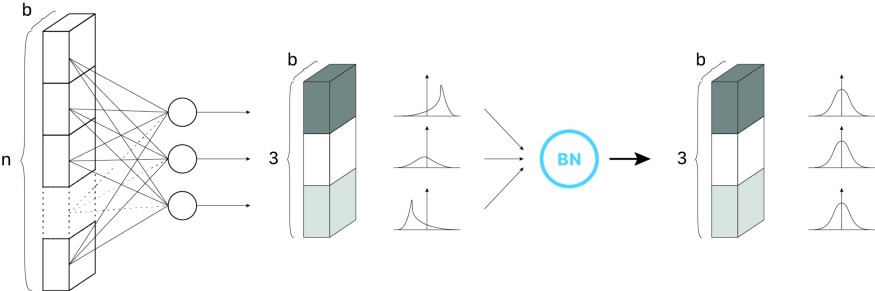

## Create the Model 

In [ ]:
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Conv2D(
            64, kernel_size=3, padding="same", use_bias=False, input_shape=[32, 32, 3]
        ),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.MaxPooling2D(2),
        tf.keras.layers.Conv2D(128, kernel_size=3, padding="same", use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Conv2D(128, kernel_size=3, use_bias=False, padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.MaxPooling2D(2),
        tf.keras.layers.Conv2D(256, kernel_size=3, use_bias=False, padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Conv2D(256, kernel_size=3, use_bias=False, padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.MaxPooling2D(2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Dense(64, use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Dense(10, activation="softmax"),
    ]
)

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 32, 32, 64)        1728      
                                                                 
 batch_normalization_14 (Bat  (None, 32, 32, 64)       256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 32, 32, 64)        0         
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_16 (Conv2D)          (None, 16, 16, 128)       73728     
                                                                 
 batch_normalization_15 (Bat  (None, 16, 16, 128)     

Above you can see that  we are using the BN layer after Conv2d layer and the Danse layers addition to setting the ues_base to False . The height and width dimensions stay the same since we're using `same` padding, however the height and width shrinked by half when passed via a `MaxPooling2D` layer since the default size of the pooling filter is 2x2.

The number of output channels for each Conv2D layer is controlled by the first argument (e.g., 32 , 64 or 128). Typically, as the width and height shrink, you can afford (computationally) to add more output channels in each Conv2D layer.

As you can see, our (4, 4, 256) outputs from the max_pooling2d_6 were flattened into vectors of shape (4096) before going through three Dense layers.

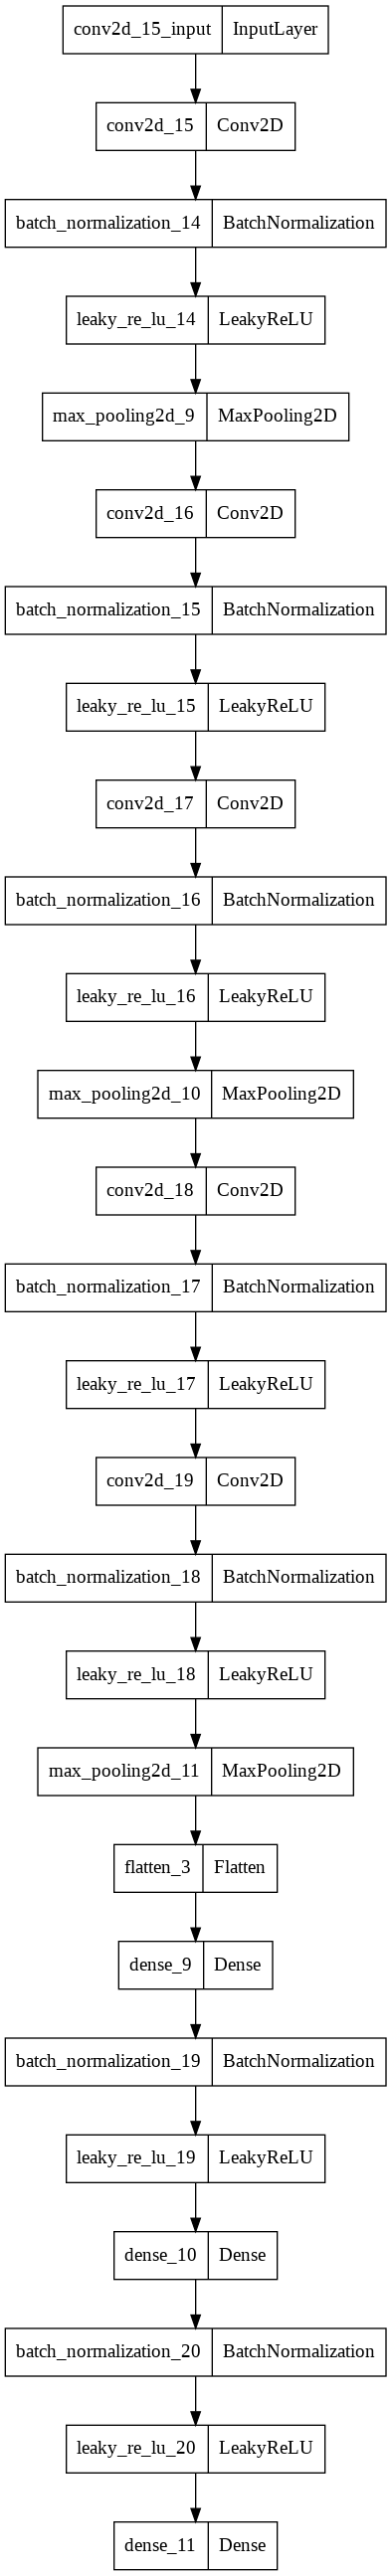

In [ ]:
tf.keras.utils.plot_model(model)

• The first layer uses 64  filters (3 × 3). It also sets input_shape=[32, 32, 3], because the
images are 32 × 32 pixels, with a 3 color channel (i.e., RGB)

• Next we have a BN layer which uses to Normalizing the outpout of the above layer.

• than we have the Activation layer.

• at the end we have a max pooling layer which uses a pool size of 2, so it divides each spatial dimension by a factor of 2.

• Then we repeat the same structure twice: two convolutional layers followed by a max pooling layer. For larger images, we could repeat this structure several more times (the number of repetitions is a hyperparameter you can tune).


• Next is the fully connected network, composed of two hidden dense layers and a dense output layer. Note that we must flatten its inputs, since a dense network expects a 1D array of features for each instance. We also add two dropout layers,without a dropout because we are using the BN layer.


##train the model with the BN layers

In [ ]:
model.compile(
    optimizer=tf.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=["accuracy"],
)

model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))

Epoch 1/5
1563/1563 [==============================] - 69s 20ms/step - loss: 1.1842 - accuracy: 0.5777 - val_loss: 1.1020 - val_accuracy: 0.6212
Epoch 2/5
1563/1563 [==============================] - 31s 20ms/step - loss: 0.8132 - accuracy: 0.7149 - val_loss: 0.8436 - val_accuracy: 0.7097
Epoch 3/5
1563/1563 [==============================] - 31s 20ms/step - loss: 0.6706 - accuracy: 0.7668 - val_loss: 0.7269 - val_accuracy: 0.7483
Epoch 4/5
1563/1563 [==============================] - 31s 20ms/step - loss: 0.5632 - accuracy: 0.8040 - val_loss: 0.7648 - val_accuracy: 0.7395
Epoch 5/5
1563/1563 [==============================] - 31s 20ms/step - loss: 0.4731 - accuracy: 0.8348 - val_loss: 0.6154 - val_accuracy: 0.7859


**Note :** you can notice the difference in the traing time  between the model that useing the BN layers and the model without uisng it.

we are reciting the val loss of 1 a rely in the model that using BN layers

## Plot Training History

In [ ]:
train_history = pd.DataFrame(model.history.history)
train_history

,loss,accuracy,val_loss,val_accuracy
0,1.184155,0.57766,1.101951,0.6212
1,0.813223,0.71490,0.843595,0.7097
2,0.670631,0.76684,0.726912,0.7483
3,0.563184,0.80404,0.764841,0.7395
4,0.473101,0.83480,0.615439,0.7859


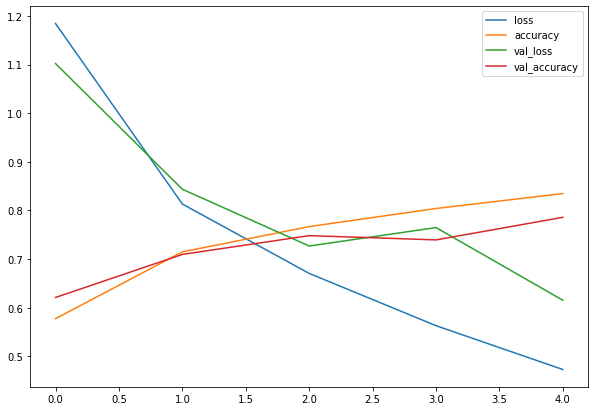

In [ ]:
train_history.plot(figsize=(10, 7))